In [ ]:
import torch
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm
import vegas

Using device: cuda


In [68]:
def sim_revexp_T_mgpd(n, d, a, beta, sig, gamma, MGPD=True, std=False):

    E = np.random.exponential(1, n )[:,None]
    T_total = []
    for j in range(d):
        U = np.random.uniform(0, 1, n)
        T = a[j]*np.log(U) - beta[j]
        T_total.append(T)
    T_total = np.column_stack(T_total)

    S = T_total - np.max(T_total, axis=1)[:,None]
    Z = E + S 

    if std and not MGPD:
        return Z

    X = []
    for j in range(d):
        if gamma[j] != 0:
            X.append(sig[j] * (np.exp(Z[:, j] * gamma[j]) - 1) / gamma[j])
        else:
            X.append(sig[j] * Z[:, j])
    X = np.column_stack(X)

    if MGPD and not std:
        return X
    if std and MGPD:
        return {'X': X, 'Z': Z}


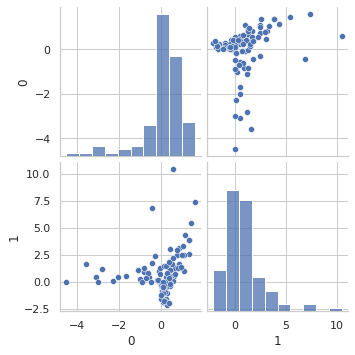

In [70]:
n_samples = 100
n_experiments = 100    
d = 2
a = np.array([2,0.5,1, 5,1.5])
beta = np.array([1, 2,3,4,5])
sig = np.array([0.5, 1.2, 1, 1.5, 0.8])
gamma = np.array([-0.1, 0.2, 0, 0.15, -0.05])
samples = sim_revexp_T_mgpd(n_samples, 2, a, beta, sig, gamma)

# samples = sim_revexp_T_mgpd(n_samples, 2, a[3:], beta[3:], sig[3:], gamma[3:])
sns.pairplot(pd.DataFrame(samples), diag_kws={'bins': 10})

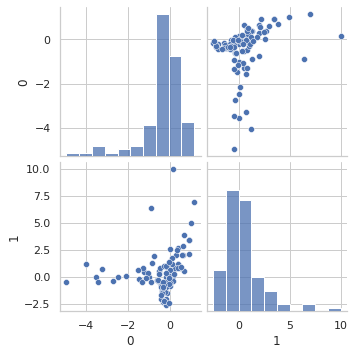

In [73]:
samples1 = samples - np.mean(samples)
sns.pairplot(pd.DataFrame(samples1), diag_kws={'bins': 10})

In [48]:
word1 = "abbzzca"
word2 = "babzzcz"
dict1 = {}
dict2 = {}
for w in word1:
    dict1[w] = dict1.get(w,0) + 1
for w in word2:
    dict2[w] = dict2.get(w,0) + 1

In [54]:
dict2[['a']]

TypeError: unhashable type: 'list'

In [45]:
dir_out = "/home/pgrad2/2448355h/My_PhD_Project/01_Output/GPDFlow/"
n_samples = 100
n_experiments = 40    
d = 2
a = np.array([2,0.5,1, 5,1.5])
beta = np.array([1, 2,3,4,5])
sig = np.array([0.5, 1.2, 1, 1.5, 0.8])
gamma = np.array([-0.1, 0.2, 0, 0.15, -0.05])

def chi_theorical(alpha1, alpha2):
    if alpha1 <= 0 or alpha2 <= 0:
        raise ValueError("alpha1 and alpha2 must be greater than 0")
    
    # Identify alpha_(1) = max(alpha1, alpha2) and alpha_(2) = min(alpha1, alpha2)
    alpha_max = max(alpha1, alpha2)
    alpha_min = min(alpha1, alpha2)
    
    # Calculate the components of the formula
    term1 = (1 + 1 / alpha_max) / (1 + 1 / alpha_min)
    term1_power = term1 ** (1 + alpha_min)
    term2 = (alpha_max / alpha_min) * (1 / (1 + alpha1 + alpha2))
    
    # Final chi value
    chi = 1 - term1_power * term2
    return chi

def pairwise_chi_theorical(alpha_vector):
    n = len(alpha_vector)
    chi_dict = {}
    
    for i in range(n-1):
        for j in range(i+1,n):
            chi_dict[f"{i+1}-{j+1}"] =  chi_theorical(alpha_vector[i], alpha_vector[j])
    
    return chi_dict
chi_values_theorical = pairwise_chi_theorical(1/a)
chi_values_theorical

def empirical_upper_tail_dependence(X, p):

    # Compute the quantiles
    quantile = np.quantile(X, p, axis = 0)
    
    # Count joint exceedances
    joint_exceedance = np.sum((X[:,0] > quantile[0]) & (X[:,1] > quantile[1]))
    exceedance_X1 = np.sum(X[:,0] > quantile[0])
    
    # Calculate lambda_u
    if exceedance_X1 == 0:  # Avoid division by zero
        return 0.0
    chi_u = joint_exceedance / exceedance_X1
    return chi_u


def pairwise_chi_empirical(dim, model, n_monte_carlo, n_experiments):
    probs = np.linspace(0.80, 0.996, 100)
    # Compute lambda_u for each quantile
    sample_chi = {}
    for i in range(dim-1):
        for j in range(i+1,dim):
            chi_values = []
            for _ in range(n_experiments):  # Step 3: Repeat 200 times
                model.load_state_dict(torch.load(dir_out + f'model_5D_100_{_}.pt', weights_only=True))
                model.eval()
                samples_obs, samples_std, samples_T= model.sample(n_monte_carlo)
                sampled_data = samples_obs.cpu().data.numpy()
                chi_values.append(empirical_upper_tail_dependence(sampled_data[:,[i,j]], 0.99))
            sample_chi[f"{i+1}-{j+1}"] =  chi_values
    
    return sample_chi

In [41]:
dim = 5
base = nf.distributions.DiagGaussian(dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_layers = 16
torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

batch_size = 64
loss_history = []
epochs = 200

model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=10000, fix_margin=False)
chi_values_empipical = pairwise_chi_empirical(dim=5, model=model,  n_monte_carlo=10000, n_experiments=n_experiments)

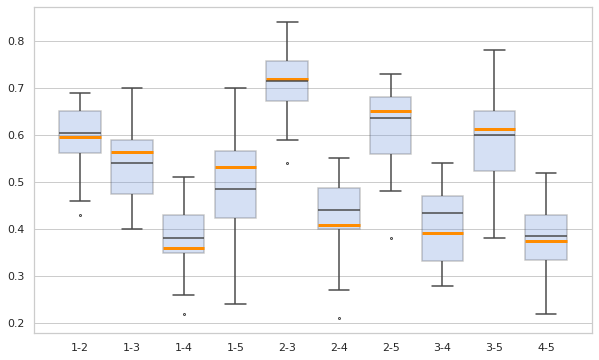

In [42]:
df = pd.DataFrame(chi_values_empipical)

# Create the boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, color="cornflowerblue", fliersize=2, linewidth=1.5, boxprops=dict(alpha=0.3))
# ax.xaxis.grid(True)  # Enable vertical gridlines
# ax.yaxis.grid(True) 
for i, pair_index in enumerate(chi_values_theorical):
    plt.hlines(y=chi_values_theorical[pair_index], xmin=i - 0.4, xmax=i + 0.4, color='darkorange', linewidth=3)

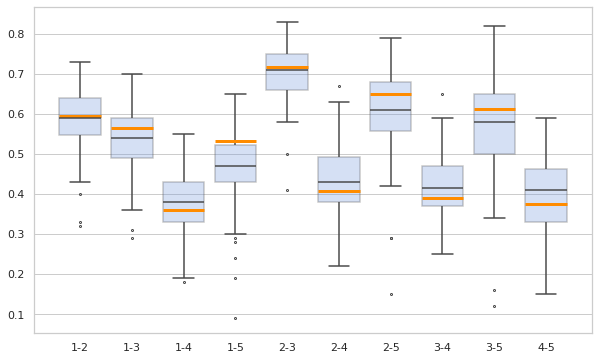

In [64]:
dim = 5
base = nf.distributions.DiagGaussian(dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_layers = 16
torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

batch_size = 64
loss_history = []
epochs = 200

model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=10000, fix_margin=False)
chi_values_empipical = pairwise_chi_empirical(dim=5, model=model,  n_monte_carlo=10000, n_experiments=100)
df = pd.DataFrame(chi_values_empipical)

# Create the boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, color="cornflowerblue", fliersize=2, linewidth=1.5, boxprops=dict(alpha=0.3))
# ax.xaxis.grid(True)  # Enable vertical gridlines
# ax.yaxis.grid(True) 
for i, pair_index in enumerate(chi_values_theorical):
    plt.hlines(y=chi_values_theorical[pair_index], xmin=i - 0.4, xmax=i + 0.4, color='darkorange', linewidth=3)

In [67]:
len(chi_values_empipical['1-2'])

100

In [61]:
sigma_dict = {f'sigma_{i}': [] for i in range(dim)}
gamma_dict = {f'gamma_{i}': [] for i in range(dim)}

for _ in range(80):  # Step 3: Repeat 200 times
    model.load_state_dict(torch.load(dir_out + f'model_5D_100_{_}.pt', weights_only=True))
    model.eval()
    sigma_hat = model.data_transform.get_sigma().cpu().data.numpy()
    gamma_hat = model.data_transform.get_gamma().cpu().data.numpy()
    for i in range(dim):
        sigma_dict[f'sigma_{i}'].append(np.log(sigma_hat[i]))
        gamma_dict[f'gamma_{i}'].append(gamma_hat[i])

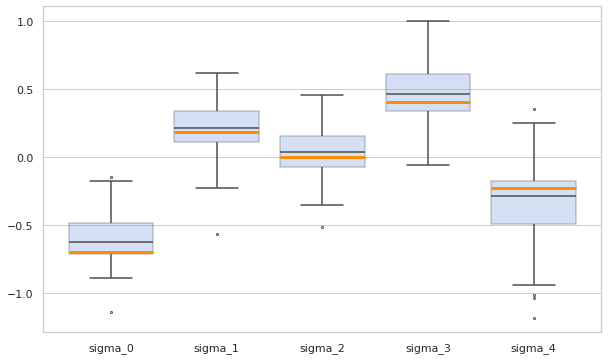

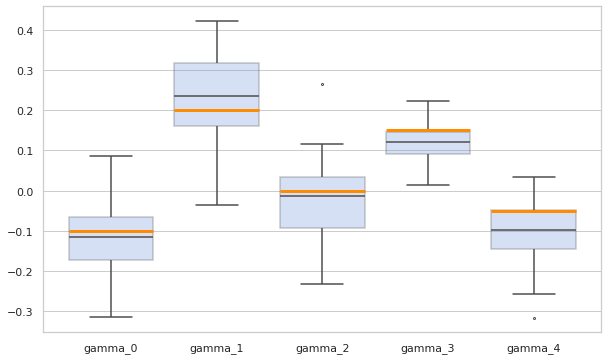

In [62]:
df_sigma = pd.DataFrame(sigma_dict)

# Create the boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_sigma, color="cornflowerblue", fliersize=2, linewidth=1.5, boxprops=dict(alpha=0.3))
# ax.xaxis.grid(True)  # Enable vertical gridlines
# ax.yaxis.grid(True) 
for i in range(dim):
    plt.hlines(y=np.log(sig[i]), xmin=i - 0.4, xmax=i + 0.4, color='darkorange', linewidth=3)



df_gamma = pd.DataFrame(gamma_dict)

# Create the boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_gamma, color="cornflowerblue", fliersize=2, linewidth=1.5, boxprops=dict(alpha=0.3))
# ax.xaxis.grid(True)  # Enable vertical gridlines
# ax.yaxis.grid(True) 
for i in range(dim):
    plt.hlines(y=gamma[i], xmin=i - 0.4, xmax=i + 0.4, color='darkorange', linewidth=3)

In [20]:
import math

def f(x):
    dx2 = 0
    for d in range(4):
        dx2 += (x[d] - 0.5) ** 2
    return math.exp(-dx2 * 100.) * 1013.2118364296088

integ = vegas.Integrator([[-1,0]] +[[0,1] for _ in range(25)])

result = integ(f, nitn=10, neval=1000)
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   2.2(1.2)e-13    2.2(1.2)e-13        0.00     1.00
  2   2.8(2.5)e-13    2.3(1.0)e-13        0.05     0.82
  3   6.9(3.6)e-13    2.6(1.0)e-13        0.78     0.46
  4   4.9(2.2)e-13    3.02(92)e-13        0.83     0.48
  5   7.4(2.5)e-13    3.54(86)e-13        1.29     0.27
  6   3.85(65)e-13    3.74(52)e-13        1.05     0.39
  7   7.3(2.0)e-13    3.96(50)e-13        1.36     0.23
  8   7.8(2.7)e-13    4.08(49)e-13        1.44     0.18
  9   6.9(1.0)e-13    4.60(44)e-13        2.00     0.04
 10   7.4(1.3)e-13    4.90(42)e-13        2.24     0.02

result = 4.90(42)e-13    Q = 0.02


In [33]:
K = 64
torch.manual_seed(0)

latent_size = 3
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(K):
    s = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]

# Set target and q0
target = nf.distributions.TwoModes(2, 0.1)
q0 = nf.distributions.DiagGaussian(3)

# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)
nfm = nfm.double()

# # Initialize ActNorm
# z, _ = nfm.sample(num_samples=2 ** 7)
# z_np = z.to('cpu').data.numpy()
# plt.figure(figsize=(15, 15))
# plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (200, 200), range=[[-3, 3], [-3, 3]])
# plt.gca().set_aspect('equal', 'box')
# plt.show()

In [26]:
nf.flows.ActNorm?

In [34]:
nfm.sample(num_samples=2 ** 7)

(tensor([[-0.2310, -0.2466,  0.2542],
         [-2.2561,  0.2985,  0.6747],
         [ 0.0110,  0.7697, -0.1960],
         [-0.3830,  0.3615,  1.4689],
         [-1.8308, -0.2434,  1.4231],
         [ 1.4952, -1.3010,  0.0448],
         [-1.4006, -1.5375,  0.8261],
         [-0.2512, -0.9926, -0.4794],
         [ 3.3470, -0.1726, -1.6598],
         [ 1.4229, -0.6594, -0.7005],
         [-1.3513, -0.3014, -0.1973],
         [-0.5242, -0.2385,  0.1218],
         [-0.6400, -0.1468,  1.4666],
         [-1.8371,  0.5541, -0.6326],
         [ 1.2369,  1.1436,  0.2803],
         [ 0.1570, -0.6331,  0.2227],
         [-0.1866, -1.0101,  0.7032],
         [-1.0066,  0.8973,  0.3347],
         [-0.2482, -1.0921,  0.6724],
         [-0.1055, -0.8088, -1.0538],
         [-1.4080, -1.0828, -1.4317],
         [ 0.0810, -0.0929,  0.9800],
         [-0.6054,  0.6620,  0.5119],
         [ 0.2031,  1.7305,  0.3904],
         [ 0.4066, -1.2152, -1.4456],
         [-0.8567, -1.2097, -0.0196],
         [ 1

In [23]:
nfm.forward(torch.tensor([1.0,20.0],device=device))

tensor([[nan, nan]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)

In [3]:
nf.NormalizingFlow(q0=q0, flows=flows, p=target).forward(torch.tensor([1.0,20.0],device=device))

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/normflows/flows/normalization.py:23: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  s_init = -torch.log(z.std(dim=self.batch_dims, keepdim=True) + 1e-6)


tensor([[nan, nan]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)

In [127]:
np.exp(np.max(samples,axis=1))

/tmp/ipykernel_2322888/1977296910.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(np.max(samples,axis=1))


array([inf, inf, inf, ..., inf, inf, inf])

In [128]:
np.log(np.exp(np.max(samples,axis=1)).mean())

/tmp/ipykernel_2322888/1160389807.py:1: RuntimeWarning: overflow encountered in exp
  np.log(np.exp(np.max(samples,axis=1)).mean())


inf

In [129]:
max_U = torch.tensor(np.max(samples,axis=1) ) # shape: (batch_size,)

# We want log( mean( exp(max_U) ) ) over the batch dimension
log_E_exp_max_U = log_mean_exp(max_U, dim=0)
log_E_exp_max_U

tensor(2028.5075, dtype=torch.float64)

In [130]:
U_samples = f_U_model.sample((num_U_samples,))
max_U = torch.max(U_samples, dim=1)[0]
E_exp_max_U = torch.mean(torch.exp(max_U))

max_U = torch.max(U_samples, dim=1)[0]

# 2) Shift and exponentiate
shifted_exp = torch.exp(x - x_max)

# 3) Average, then take log
mean_shifted_exp = torch.mean(shifted_exp, dim=dim, keepdim=True)
log_mean_shifted_exp = torch.log(mean_shifted_exp)

# 4) Add the max back
out = x_max + log_mean_shifted_exp

NameError: name 'dim' is not defined

In [3]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA RTX A6000 is available.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
a = [1,2,3]
# a.pop()
print(a)

[1, 2, 3]


In [158]:
class Node(object):
    def __init__(self, val=0, next=None):
        self.val = val
        self.next = next
        
node1 = Node(1)
node2 = Node(2)
node3 = Node(3)
node4 = Node(4)
node5 = Node(5)

node1.next = node2
node2.next = node3
node3.next = node4
node4.next = node5

In [83]:
node_odd = node1

In [107]:
print(node4.next.val)

AttributeError: 'NoneType' object has no attribute 'val'

In [90]:
node_odd.next.val

13

In [157]:
def oddEvenList(head):
    """
    :type head: Optional[ListNode]
    :rtype: Optional[ListNode]
    """
    node_odd = head
    node_oven = head.next
    count = 1
    while node_odd.next and node_odd.next.next:
        node_odd.next = node_odd.next.next
        node_odd = node_odd.next
    while node_oven.next and node_oven.next.next:
        print(node_oven.val)
        print(node_oven.next.val)
        print(node_oven.next.next.val)
        node_oven.next = node_oven.next.next 
        if count == 1:
             node_oven_start = node_oven
        node_oven = node_oven.next
        print(node_oven.val)
        count += 1

    node_oven.next = None
    node_odd.next = node_oven_start
    return head

In [159]:
oddEvenList(node1)

2
3
5
5


In [147]:
head = node1
count = 1
while head and count<=10:
    print(head.val)
    head = head.next
    count += 1

1
3
5
2
5
2
5
2
5
2


Epoch 1/50, Loss: 0.4123
Epoch 2/50, Loss: 0.1382
Epoch 3/50, Loss: 0.1233
Epoch 4/50, Loss: 0.1205
Epoch 5/50, Loss: 0.1170
Epoch 6/50, Loss: 0.1212
Epoch 7/50, Loss: 0.1143
Epoch 8/50, Loss: 0.1144
Epoch 9/50, Loss: 0.1116
Epoch 10/50, Loss: 0.1100
Epoch 11/50, Loss: 0.1123
Epoch 12/50, Loss: 0.1083
Epoch 13/50, Loss: 0.1062
Epoch 14/50, Loss: 0.1053
Epoch 15/50, Loss: 0.1002
Epoch 16/50, Loss: 0.0999
Epoch 17/50, Loss: 0.0997
Epoch 18/50, Loss: 0.0936
Epoch 19/50, Loss: 0.0886
Epoch 20/50, Loss: 0.0818
Epoch 21/50, Loss: 0.0719
Epoch 22/50, Loss: 0.0631
Epoch 23/50, Loss: 0.0654
Epoch 24/50, Loss: 0.0661
Epoch 25/50, Loss: 0.0538
Epoch 26/50, Loss: 0.0481
Epoch 27/50, Loss: 0.0445
Epoch 28/50, Loss: 0.0406
Epoch 29/50, Loss: 0.0381
Epoch 30/50, Loss: 0.0374
Epoch 31/50, Loss: 0.0346
Epoch 32/50, Loss: 0.0349
Epoch 33/50, Loss: 0.0332
Epoch 34/50, Loss: 0.0319
Epoch 35/50, Loss: 0.0307
Epoch 36/50, Loss: 0.0301
Epoch 37/50, Loss: 0.0305
Epoch 38/50, Loss: 0.0286
Epoch 39/50, Loss: 0.

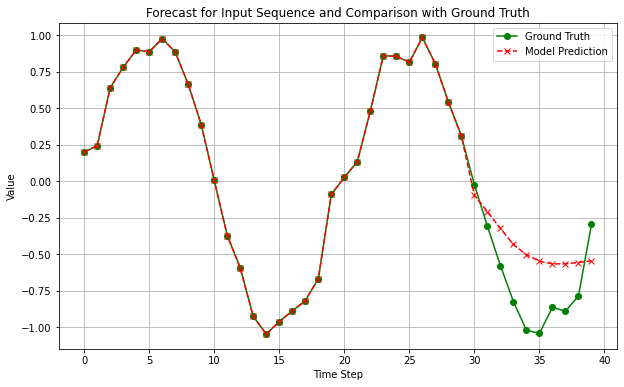

In [58]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# -------------------------------
# Positional Encoding
# -------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        Implements the sinusoidal positional encoding for the Transformer.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)  # shape: (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)
        Returns:
            Tensor of shape (batch_size, seq_len, d_model) with positional encodings added.
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------
# Transformer Model for Time-Series Forecasting
# -------------------------------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers,
                 num_decoder_layers, dim_feedforward, dropout=0.1):
        """
        A Transformer-based model for time-series forecasting.
        Args:
            input_size: Number of features in the input time-series (use 1 for univariate).
            d_model: Dimension of the embedding.
            nhead: Number of heads in multi-head attention.
            num_encoder_layers: Number of encoder layers.
            num_decoder_layers: Number of decoder layers.
            dim_feedforward: Dimension of the feedforward network.
            dropout: Dropout rate.
        """
        super(TimeSeriesTransformer, self).__init__()
        self.d_model = d_model

        # Project the input to the model dimension
        self.input_linear = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_decoder = PositionalEncoding(d_model, dropout)

        # The Transformer module (using batch_first=True so that inputs are (batch, seq, feature))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Project back to the output dimension
        self.output_linear = nn.Linear(d_model, input_size)

    def forward(self, src, tgt):
        """
        Args:
            src: Source sequence (encoder input) of shape (batch_size, src_seq_len, input_size)
            tgt: Target sequence (decoder input) of shape (batch_size, tgt_seq_len, input_size)
        Returns:
            Output predictions of shape (batch_size, tgt_seq_len, input_size)
        """
        # Embed and add positional encodings
        src = self.input_linear(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        tgt = self.input_linear(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_decoder(tgt)
        
        # Pass through the Transformer module
        output = self.transformer(src, tgt)
        output = self.output_linear(output)
        return output

# -------------------------------
# Dataset for Time-Series Data
# -------------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, series, input_window, output_window):
        """
        Uses a sliding-window approach to extract samples from a 1D time-series.
        Each sample consists of a past window (input) and the following window (target).
        """
        self.series = series
        self.input_window = input_window
        self.output_window = output_window

    def __len__(self):
        return len(self.series) - self.input_window - self.output_window + 1

    def __getitem__(self, idx):
        # Get the input and target sequences from the time-series
        x = self.series[idx: idx + self.input_window]
        y = self.series[idx + self.input_window: idx + self.input_window + self.output_window]
        # Reshape to (window_length, 1) for a univariate series
        return (torch.tensor(x, dtype=torch.float32).unsqueeze(-1),
                torch.tensor(y, dtype=torch.float32).unsqueeze(-1))

# -------------------------------
# Synthetic Data Generation
# -------------------------------
def generate_sine_wave(seq_length, freq=0.05, noise=0.1):
    """
    Generates a noisy sine wave.
    Args:
        seq_length: Total number of points.
        freq: Frequency of the sine wave.
        noise: Standard deviation of Gaussian noise.
    Returns:
        A NumPy array containing the sine wave.
    """
    x = np.arange(seq_length)
    y = np.sin(2 * np.pi * freq * x) + np.random.normal(scale=noise, size=seq_length)
    return y

# -------------------------------
# Training Loop and Visualization
# -------------------------------
def main():
    # Hyperparameters
    input_window = 30    # Number of time steps for the input sequence
    output_window = 10   # Number of time steps to predict
    batch_size = 32
    num_epochs = 50
    d_model = 64
    nhead = 8
    num_encoder_layers = 3
    num_decoder_layers = 3
    dim_feedforward = 128
    dropout = 0.1
    learning_rate = 0.001

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Generate synthetic time-series data (a noisy sine wave)
    seq_length = 1000
    series = generate_sine_wave(seq_length)

    # Create the dataset and data loader
    dataset = TimeSeriesDataset(series, input_window, output_window)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize the model, loss function, and optimizer
    model = TimeSeriesTransformer(input_size=1, d_model=d_model, nhead=nhead,
                                  num_encoder_layers=num_encoder_layers,
                                  num_decoder_layers=num_decoder_layers,
                                  dim_feedforward=dim_feedforward,
                                  dropout=dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for src, tgt in dataloader:
            src = src.to(device)  # Shape: (batch_size, input_window, 1)
            tgt = tgt.to(device)  # Shape: (batch_size, output_window, 1)

            optimizer.zero_grad()

            # For teacher forcing: supply a start-of-sequence token (0) followed by target sequence (excluding last time step).
            sos = torch.zeros(src.size(0), 1, 1, device=device)  # (batch_size, 1, 1)
            decoder_input = torch.cat([sos, tgt[:, :-1, :]], dim=1)  # (batch_size, output_window, 1)

            # Forward pass
            output = model(src, decoder_input)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # -------------------------------
    # Visualization: Forecasting on an Input Sequence
    # -------------------------------
    model.eval()

    # Select a sample from the dataset.
    # For example, choose the sample starting at index 100.
    sample_index = 100
    src_sample, tgt_sample = dataset[sample_index]  # src_sample: (input_window, 1), tgt_sample: (output_window, 1)
    src_sample = src_sample.unsqueeze(0).to(device)  # (1, input_window, 1)
    # Note: We won't use tgt_sample for generation, but we can use it for comparing ground truth.
    
    # Autoregressive prediction:
    # We generate the forecast by feeding the model its own prediction.
    # The decoder starts with a start-of-sequence token (0).
    decoder_input = torch.zeros(1, 1, 1, device=device)
    predictions = []
    for _ in range(output_window):
        out = model(src_sample, decoder_input)
        # Get the last predicted time step
        next_val = out[:, -1:, :]  # (1, 1, 1)
        predictions.append(next_val.item())
        # Append the prediction to the decoder input for the next iteration
        decoder_input = torch.cat([decoder_input, next_val], dim=1)

    predictions = np.array(predictions)

    # Prepare the full predicted series by appending the forecast to the input sequence.
    input_seq = src_sample[0, :, 0].cpu().numpy()
    full_prediction = np.concatenate([input_seq, predictions])
    
    # Ground truth: from the original series, get the values covering the input window and the following output window.
    ground_truth = series[sample_index: sample_index + input_window + output_window]

    # Create a time axis covering both input and prediction steps.
    time_axis = np.arange(input_window + output_window)

    # Plot the input sequence with the forecast alongside the ground truth.
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis, ground_truth, label="Ground Truth", marker="o", color="green")
    plt.plot(time_axis, full_prediction, label="Model Prediction", marker="x", linestyle="--", color="red")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Forecast for Input Sequence and Comparison with Ground Truth")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

# Load data from a CSV file into a PandasDataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/"
    "TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv",
    index_col=0,
    parse_dates=True,
)
dataset = PandasDataset(df, target="#Passengers")

# Split the data for training and testing
training_data, test_gen = split(dataset, offset=-36)
test_data = test_gen.generate_instances(prediction_length=12, windows=3)

# Train the model and make predictions
model = DeepAREstimator(
    prediction_length=12, freq="M", trainer_kwargs={"max_epochs": 5}
).train(training_data)

forecasts = list(model.predict(test_data.input))

# Plot predictions
plt.plot(df["1954":], color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                   | Out sizes   
--------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 23.3 K | train | [[1, 1], [1, 1], [1, 48, 2], [1, 48], [1, 48], [1, 12, 2]] | [1, 100, 12]
--------------------------------------------------------------------------------------------------------------------------
23.3 K    Trainable params
0         Non-trainable params
23.3 K    Total params
0.093     Total estimated model params size (MB)
11        Modules in train mode
0  

Training: |                                                                                                   …

Epoch 0, global step 50: 'train_loss' reached 5.91129 (best 5.91129), saving model to '/home/pgrad2/2448355h/My_PhD_Project/GPDFlow/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.78904 (best 4.78904), saving model to '/home/pgrad2/2448355h/My_PhD_Project/GPDFlow/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.44690 (best 4.44690), saving model to '/home/pgrad2/2448355h/My_PhD_Project/GPDFlow/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.34315 (best 4.34315), saving model to '/home/pgrad2/2448355h/My_PhD_Project/GPDFlow/lightning_logs/version_1/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.22652 (best 4.22652), saving model to '/home/pgrad2/2448355h/My_PhD_Project/GPDFlow/lightning_logs/version_1/checkpoints/epoch=4-step=250.ckpt' a

AttributeError: 'TrainingDataset' object has no attribute 'input'

In [6]:
test_data.input

InputDataset(test_data=TestData(dataset=PandasDataset<size=1, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>, splitter=OffsetSplitter(offset=-36), prediction_length=12, windows=3, distance=None, max_history=None))

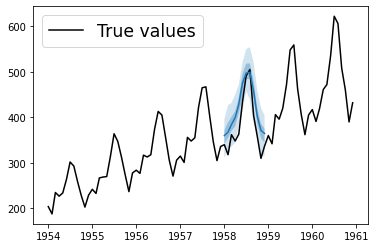

In [7]:
forecasts = list(model.predict(training_data))

# Plot predictions
plt.plot(df["1954":], color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")
plt.show()